In [1]:
# parameters
INPUT_DATA_PATH = "../data/interim/"
INPUT_PROCESSED_DATA_PATH = "../data/processed/"

YEAR = 2017
SAVE_OUTPUT = True
OUTPUT_DATA_PATH = "../data/processed/"
OUTPUT_FIGURES_PATH = "../reports/figures/"

In [2]:
# Parameters
YEAR = 2024
SAVE_OUTPUT = True


In [3]:
# Import all necessary libraries
import time
start = time.time()
import geopandas as gpd
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import seaborn as sns

import warnings
from pathlib import Path


# Load data

In [4]:
# Read expansion factors from the input path
hod_weekday = pd.read_parquet(Path(INPUT_DATA_PATH) / f"expansion_factors/hod_weekday_{YEAR}.parquet")
hod_weekend = pd.read_parquet(Path(INPUT_DATA_PATH) / f"expansion_factors/hod_weekend_{YEAR}.parquet")
dow_factor = pd.read_parquet(Path(INPUT_DATA_PATH) / f"expansion_factors/dow_factor_{YEAR}.parquet")
moy_factor = pd.read_parquet(Path(INPUT_DATA_PATH) / f"expansion_factors/moy_factor_{YEAR}.parquet")
print(hod_weekday.columns)

Index(['id', 'year', 'hour', 'Average_HOD', 'sum_of_Average_HOD', 'HOD'], dtype='object')


In [5]:
bacc = gpd.read_parquet(Path(INPUT_DATA_PATH) / f"bacc/bacc.parquet")
bacc = bacc[bacc['Year'] == YEAR]
print(bacc.shape)
print(bacc.columns)

(60, 10)
Index(['ROOT_ID', 'Year', 'Month', 'weekday', 'Day', 'Hour', 'Count',
       'Latitud', 'Longitud', 'geometry'],
      dtype='object')


# Apply Expansion factors to Short Term Counts


The code is based on what Mintu et al did on their paper. Concretely:
* The first step in covered in the notebook: **SC_data_Imputation_Daily_Volume_v3.ipynb**
* The rest of the steps are covered in the notebook: **Weekly_Annual_Volume_Estimation_Version3.ipynb**

This research developed HOD, DOW, and MOY expansion factors to impute the short-term site volume to AADBT. The imputation factor can be implemented using five sequential steps, as shown in Figure 4. To apply the expansion factors, each short-term site should collect at least one hour of bicycle traffic or volume. 

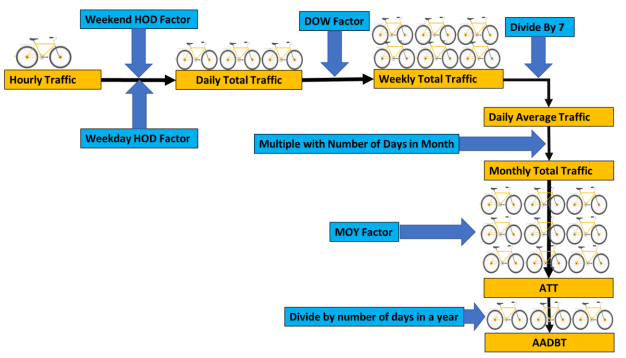

## Apply Expansion Factors

### Step 0: Prepare data

In [6]:
# #Concat the two datasets
# counts=pd.concat([bicizen,bacc])
# print(counts.shape)
# print(counts.columns)
# counts.head()
counts=bacc

In [7]:
counts_weekday = counts[counts["weekday"]<5]
counts_weekend = counts[counts["weekday"]>4]

### Step 1: Apply weekday and weekend HOD factor

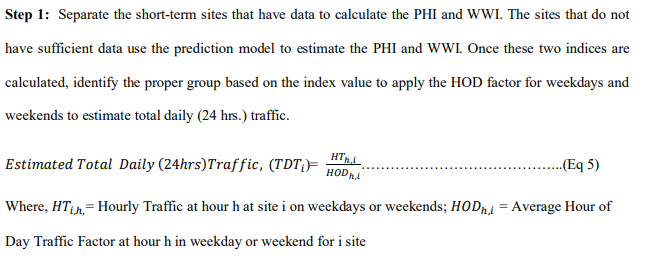

In [8]:
# Calculate daily Volume for weekday
# Merge counts_weekday data with hod_weekday factors on Year and Hour
merged_weekday_data = pd.merge(counts_weekday, hod_weekday, left_on=['Year', 'Hour'], right_on=['year', 'hour'], how='inner')

# Calculate total counts for each day and ROOT_ID
weekday_daily_counts = pd.DataFrame({'total_count': merged_weekday_data.groupby(['Year', 'Month', 'Day','weekday',  'ROOT_ID'])['Count'].sum()}).reset_index()

# Calculate total HOD factors for each day and ROOT_ID
weekday_daily_factors = pd.DataFrame({'total_factor': merged_weekday_data.groupby(['Year', 'Month', 'Day','weekday',  'ROOT_ID'])['HOD'].sum()}).reset_index()

# Merge the counts and factors dataframes
merged_weekday_counts_factors = pd.merge(weekday_daily_counts, weekday_daily_factors, on=['Year', 'Month', 'Day','weekday',  'ROOT_ID'], how='inner')

# Calculate the Daily Volume by dividing total counts by total factors
merged_weekday_counts_factors['Daily_Volume'] = merged_weekday_counts_factors['total_count'] / merged_weekday_counts_factors['total_factor']

# Calculate the mean Daily Volume (TDV) for each Year, ROOT_ID, Month, and Day
weekday_daily_volume = pd.DataFrame({'TDV': merged_weekday_counts_factors.groupby(['Year', 'ROOT_ID', 'Month','weekday',  'Day'])['Daily_Volume'].mean()}).reset_index()

weekday_daily_volume

,Year,ROOT_ID,Month,weekday,Day,TDV
0,2024,1095689,9,1,17,8217.041914
1,2024,1095689,10,2,2,8258.942854
2,2024,1095690,9,3,26,6485.284952
3,2024,1095690,10,3,3,5830.471316
4,2024,1095691,9,2,25,3153.714416
5,2024,1095691,10,1,8,3160.400736
6,2024,1095692,9,3,19,5351.730781
7,2024,1095692,10,2,9,5738.200095
8,2024,1095693,9,2,18,1693.422059
9,2024,1095693,10,3,10,1698.771115


In [9]:
# Calculate daily Volume for weekend
# Merge counts_weekend data with hod_weekend factors on Year and Hour
merged_weekend_data = pd.merge(counts_weekend, hod_weekend, left_on=['Year', 'Hour'], right_on=['year', 'hour'], how='inner')

# Calculate total counts for each day and ROOT_ID
weekend_daily_counts = pd.DataFrame({'total_count': merged_weekend_data.groupby(['Year', 'Month', 'Day', 'weekday', 'ROOT_ID'])['Count'].sum()}).reset_index()

# Calculate total HOD factors for each day and ROOT_ID
weekend_daily_factors = pd.DataFrame({'total_factor': merged_weekend_data.groupby(['Year', 'Month', 'Day', 'weekday', 'ROOT_ID'])['HOD'].sum()}).reset_index()

# Merge the counts and factors dataframes
merged_weekend_counts_factors = pd.merge(weekend_daily_counts, weekend_daily_factors, on=['Year', 'Month', 'weekday', 'Day', 'ROOT_ID'], how='inner')

# Calculate the Daily Volume by dividing total counts by total factors
merged_weekend_counts_factors['Daily_Volume'] = merged_weekend_counts_factors['total_count'] / merged_weekend_counts_factors['total_factor']

# Calculate the mean Daily Volume (TDV) for each Year, ROOT_ID, Month, and Day
weekend_daily_volume = pd.DataFrame({'TDV': merged_weekend_counts_factors.groupby(['Year', 'ROOT_ID', 'Month', 'weekday', 'Day'])['Daily_Volume'].mean()}).reset_index()

weekend_daily_volume

,Year,ROOT_ID,Month,weekday,Day,TDV


In [10]:
#Concat both datasets
daily_volume=pd.concat([weekday_daily_volume,weekend_daily_volume])
print(daily_volume.shape)

(10, 6)


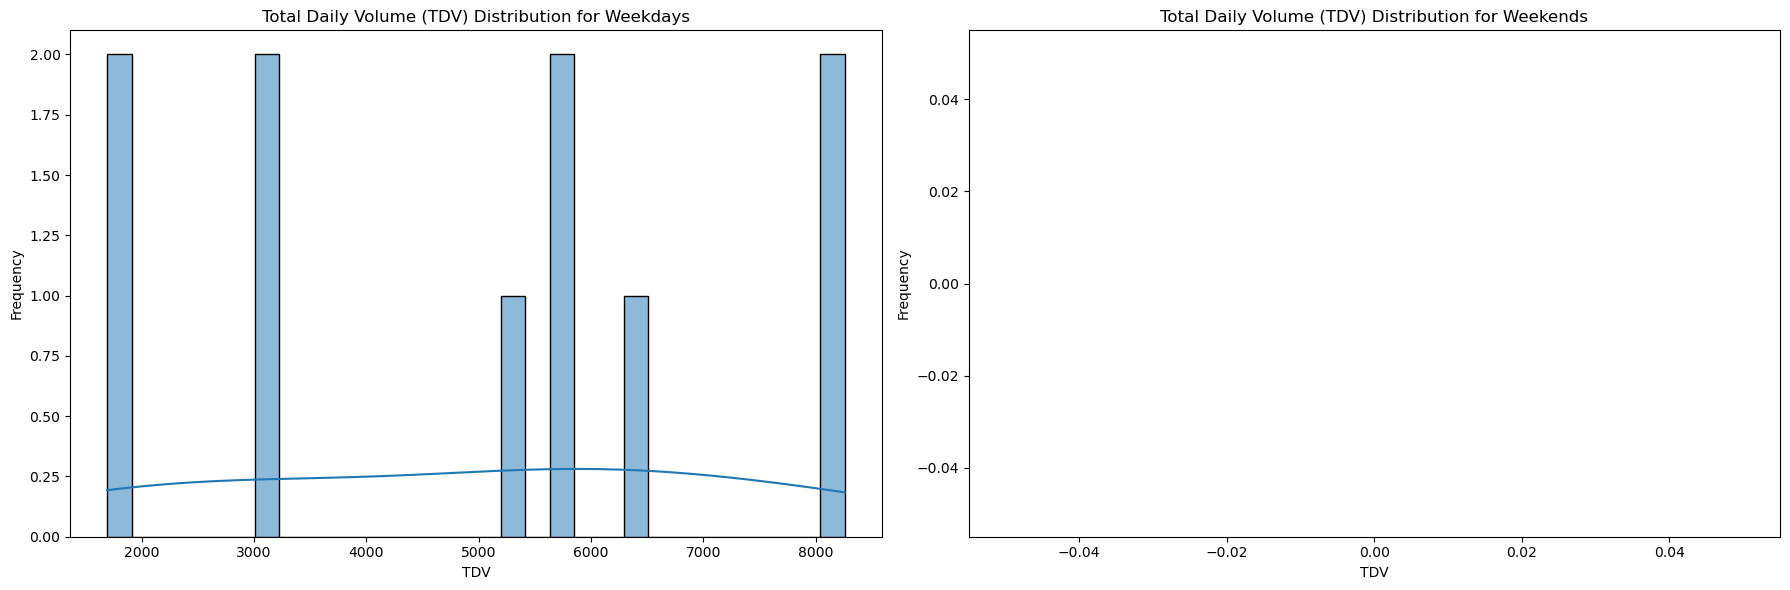

In [11]:
# Make plots of TDV for weekday and weekend side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot TDV for weekday
sns.histplot(weekday_daily_volume['TDV'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Total Daily Volume (TDV) Distribution for Weekdays')
axes[0].set_xlabel('TDV')
axes[0].set_ylabel('Frequency')

# Plot TDV for weekend
sns.histplot(weekend_daily_volume['TDV'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Total Daily Volume (TDV) Distribution for Weekends')
axes[1].set_xlabel('TDV')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Step 2: Apply DOW factor


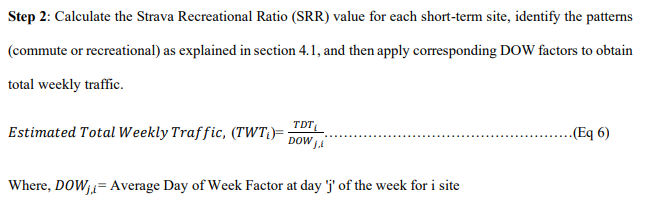

In [12]:
# Merge daily volume data with day of week (DOW) factors
merged_dow_data = pd.merge(daily_volume, dow_factor, on='weekday', how='inner')

# Aggregate weekly volume by summing daily volumes for each Year, ROOT_ID, and Month
weekly_volume_sum = merged_dow_data.groupby(['Year', 'ROOT_ID', 'Month'])['TDV'].sum().reset_index()
weekly_volume_sum.rename(columns={'TDV': 'total_weekly_volume'}, inplace=True)

# Aggregate DOW factors by summing them for each Year, ROOT_ID, and Month
weekly_dow_factor_sum = merged_dow_data.groupby(['Year', 'ROOT_ID', 'Month'])['DOW'].sum().reset_index()
weekly_dow_factor_sum.rename(columns={'DOW': 'total_dow_factor'}, inplace=True)

# Merge the weekly volume and DOW factor dataframes
merged_weekly_data = pd.merge(weekly_volume_sum, weekly_dow_factor_sum, on=['Year', 'ROOT_ID', 'Month'], how='inner')

# Calculate the weekly volume by dividing total weekly volume by total DOW factor
merged_weekly_data['Weekly_Volume'] = merged_weekly_data['total_weekly_volume'] / merged_weekly_data['total_dow_factor']

# Calculate the mean weekly volume (TWV) for each Year, ROOT_ID, and Month
mean_weekly_volume = merged_weekly_data.groupby(['Year', 'ROOT_ID', 'Month'])['Weekly_Volume'].mean().reset_index()
mean_weekly_volume.rename(columns={'Weekly_Volume': 'TWV'}, inplace=True)

mean_weekly_volume


,Year,ROOT_ID,Month,TWV
0,2024,1095689,9,52824.826251
1,2024,1095689,10,53899.843486
2,2024,1095690,9,40585.406729
3,2024,1095690,10,36487.533165
4,2024,1095691,9,20581.897273
5,2024,1095691,10,20317.240866
6,2024,1095692,9,33491.538469
7,2024,1095692,10,37448.871179
8,2024,1095693,9,11051.678832
9,2024,1095693,10,10631.038906


### Step 3: Divide by 7 to get ADBT

In [13]:
# Now divide TWV by 7 to get the weekly average volume
mean_weekly_volume['AWV'] = mean_weekly_volume['TWV'] / 7
mean_weekly_volume.head()

,Year,ROOT_ID,Month,TWV,AWV
0,2024,1095689,9,52824.826251,7546.403750
1,2024,1095689,10,53899.843486,7699.977641
2,2024,1095690,9,40585.406729,5797.915247
3,2024,1095690,10,36487.533165,5212.504738
4,2024,1095691,9,20581.897273,2940.271039


In [14]:
mean_weekly_volume['AWV'].describe()

count      10.000000
mean     4533.141074
std      2233.858635
min      1518.719844
25%      2911.914995
50%      4998.505117
75%      5685.896120
max      7699.977641
Name: AWV, dtype: float64

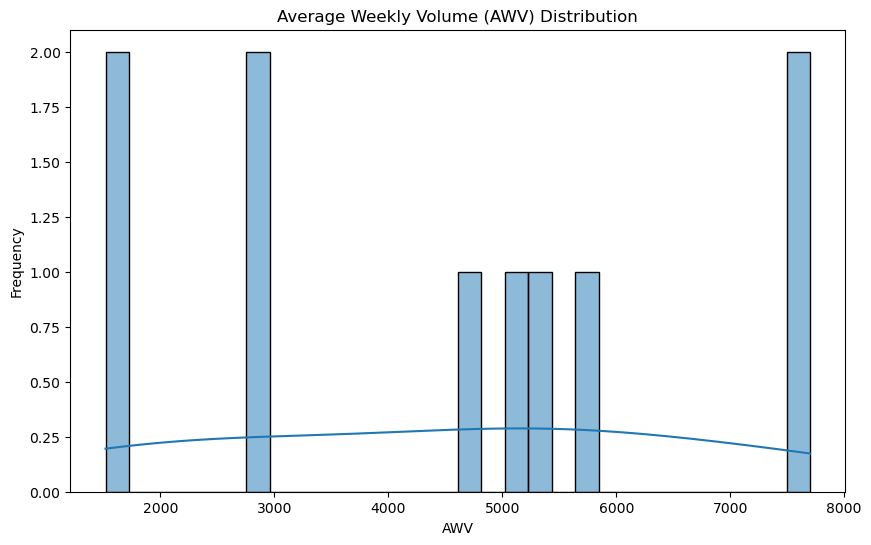

In [15]:
# Make a plot of AWV distribution
plt.figure(figsize=(10, 6))

# Plot AWV distribution
sns.histplot(mean_weekly_volume['AWV'], bins=30, kde=True)
plt.title('Average Weekly Volume (AWV) Distribution')
plt.xlabel('AWV')
plt.ylabel('Frequency')

plt.show()



### Step 4: Multiply by days of the month

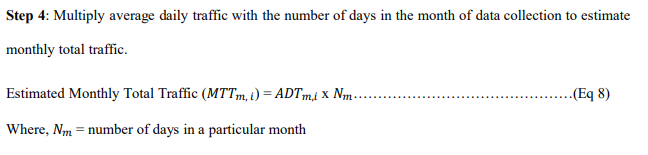

In [16]:
# Calculate the number of days in the data collection month and multiply average weekly volume (AWV) to get monthly total volume
# Create a dummy day column to get the date and days in the month
mean_weekly_volume['day'] = 1
date_columns = ["Year", "Month", "day"]
mean_weekly_volume['date'] = mean_weekly_volume[date_columns].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
mean_weekly_volume['date'] = pd.to_datetime(mean_weekly_volume['date'], errors='coerce')
mean_weekly_volume['days_in_month'] = mean_weekly_volume['date'].dt.days_in_month
mean_weekly_volume.head()

mean_monthly = mean_weekly_volume.groupby(['Year', 'Month','days_in_month', 'ROOT_ID'])['AWV'].sum().reset_index()
mean_monthly["MTT"] = mean_weekly_volume["AWV"]*mean_weekly_volume["days_in_month"]
mean_monthly["MTT"].describe()

count        10.000000
mean     138262.582604
std       68209.969777
min       47080.315155
25%       88650.186478
50%      152561.405870
75%      171914.343291
max      238699.306869
Name: MTT, dtype: float64

### Step 5: Apply MOY and divide by days in year

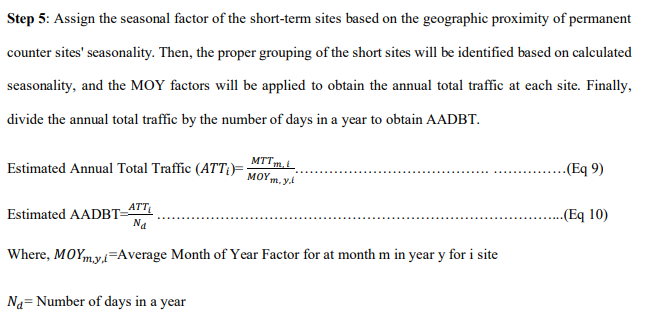

In [17]:
# Calculate Annual Volume for group 1
merged_group1 = pd.merge(mean_monthly, moy_factor[["month","MOY"]], left_on=['Month'], right_on=['month'], how='inner')

# Calculate aggregated monthly volume
agg_monthly_volume = pd.DataFrame({'agg_monthly_volume': merged_group1.groupby(['Year', 'ROOT_ID'])['MTT'].sum()}).reset_index()

# Calculate aggregated MOY factor
agg_moy_factor = pd.DataFrame({'agg_moy_factor': merged_group1.groupby(['Year', 'ROOT_ID'])['MOY'].sum()}).reset_index()

# Merge the aggregated data
merged_annual_data = pd.merge(agg_monthly_volume, agg_moy_factor, on=['Year', 'ROOT_ID'], how='inner')

# Calculate Annual Volume
merged_annual_data['Annual_Volume'] = merged_annual_data['agg_monthly_volume'] / merged_annual_data['agg_moy_factor']

# Calculate the mean Annual Volume (ATT)
annual_volume = pd.DataFrame({'ATT': merged_annual_data.groupby(['Year', 'ROOT_ID'])['Annual_Volume'].mean()}).reset_index()

annual_volume.head(5)


,Year,ROOT_ID,ATT
0,2024,1095689,1.657695e+06
1,2024,1095690,2.002817e+06
2,2024,1095691,1.780379e+06
3,2024,1095692,1.094858e+06
4,2024,1095693,7.088791e+05


In [18]:
# Convert ATT to millions
annual_volume['ATT_in_Million'] = annual_volume['ATT'] / 1000000

# Calculate AADBT
annual_volume['AADBT'] = annual_volume['ATT'] / 365

annual_volume.head()

,Year,ROOT_ID,ATT,ATT_in_Million,AADBT
0,2024,1095689,1.657695e+06,1.657695,4541.630416
1,2024,1095690,2.002817e+06,2.002817,5487.170484
2,2024,1095691,1.780379e+06,1.780379,4877.750214
3,2024,1095692,1.094858e+06,1.094858,2999.612144
4,2024,1095693,7.088791e+05,0.708879,1942.134539


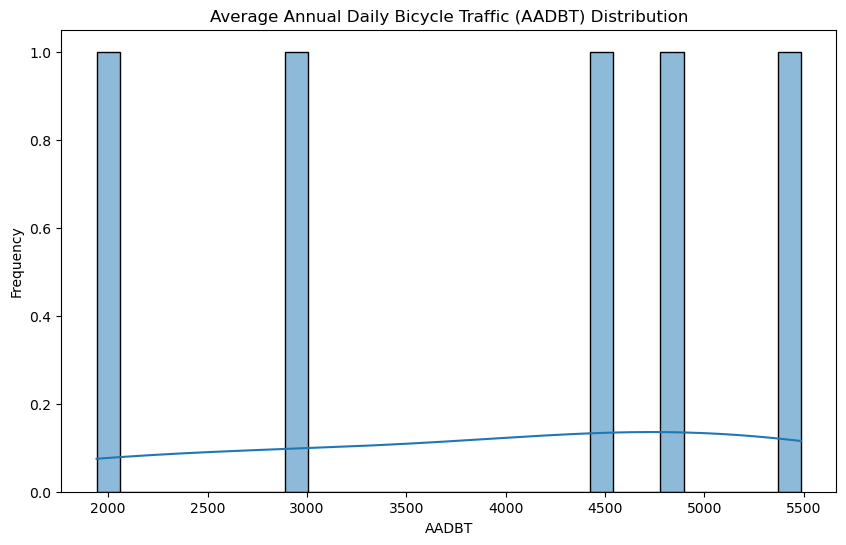

In [19]:
# Make a plot of AADBT distribution
plt.figure(figsize=(10, 6))

# Plot AADBT distribution
sns.histplot(annual_volume['AADBT'], bins=30, kde=True)
plt.title('Average Annual Daily Bicycle Traffic (AADBT) Distribution')
plt.xlabel('AADBT')
plt.ylabel('Frequency')

plt.show()



## Results

In [20]:
print(annual_volume.shape)
print(annual_volume.columns)
annual_volume['AADBT'].describe()

(5, 5)
Index(['Year', 'ROOT_ID', 'ATT', 'ATT_in_Million', 'AADBT'], dtype='object')


count       5.000000
mean     3969.659559
std      1458.292529
min      1942.134539
25%      2999.612144
50%      4541.630416
75%      4877.750214
max      5487.170484
Name: AADBT, dtype: float64

In [21]:
import plotly.express as px

# Create a combined DataFrame for plotting
combined_df = pd.DataFrame({
    'Value': pd.concat([weekday_daily_volume['TDV'], weekend_daily_volume['TDV'], mean_weekly_volume['AWV'], annual_volume['AADBT']]),
    'Category': ['Weekday TDV'] * len(weekday_daily_volume) + ['Weekend TDV'] * len(weekend_daily_volume) + ['Weekly AWV'] * len(mean_weekly_volume) + ['Annual AADBT'] * len(annual_volume)
})


# Create the box plot
fig = px.box(combined_df, x='Category', y='Value', title='Box Plots of TDV, AWV, and AADBT made with BACC data')
fig.show()

# Save output

In [22]:
# Save expansion factors separately
if SAVE_OUTPUT:
    annual_volume.to_parquet(Path(OUTPUT_DATA_PATH) / f"bacc_aadbt{YEAR}.parquet")
    # Save the figure in OUTPUT_FIGURES_PATH
    fig.write_image(Path(OUTPUT_FIGURES_PATH) / "bacc_aadbt_distribution{YEAR}.png")


